## Amazon Fine Food Reviews Analysis

#### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

* Number of reviews: 568,454
* Number of users: 256,059
* Number of products: 74,258
* Timespan: Oct 1999 - Oct 2012
* Number of Attributes/Columns in data: 10

### Attribute Information:

* Id
* ProductId - unique identifier for the product
* UserId - unqiue identifier for the user
* ProfileName
* HelpfulnessNumerator - number of users who found the review helpful
* HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
* Score - rating between 1 and 5
* Time - timestamp for the review
* Summary - brief summary of the review
* Text - text of the review

### Objective:

Visualize the reviews using t-sne plots by using Bow, tf-idf, w2v, Average w2v, tf-idf w2v

### Importing the libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer


from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

### Loading the data

In [2]:
con = sqlite3.connect('F:/Applied AI Course/Amazon fine food review dataset/database.sqlite')

In [3]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews """, con)
filtered_data.shape

(568454, 10)

In [4]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

### Removing the duplicates

In [5]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [6]:
final.shape

(364173, 10)

In [10]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


### Creating a subset of the data for visualization 

In [13]:
data_pos=final[final['Score']=='positive']
data_pos.shape
data_pos=data_pos.head(2000)

In [14]:
data_neg=final[final['Score']=='negative']

data_neg=data_neg.head(2000)

In [18]:
final=pd.concat([data_pos,data_neg],ignore_index=True)


In [19]:
final = final.sample(frac=1).reset_index(drop=True)

In [20]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,124195,B0001AVTDQ,A3MNML991T9C3S,"E. C. Smart ""geekette""",0,0,negative,1349827200,dough enhancer,"Contains milk solids, make sure this is what y..."
1,346572,B0001BGTZS,A3FWLWQC0PEGHX,"Bette B. Prater ""I buy 1cent books""",1,1,negative,1328745600,good tasty item--too expensive,Barry Farms-established in Oct 1994 by Bill<br...
2,369815,B000084DWM,A966L65JSN8XN,"N. Schleif ""night owl""",1,1,positive,1319241600,The only thing all my cats will eat!,"I have three very different cats, with very di..."
3,86272,B000084E6V,A9B0WIHS884L3,Kari Bruner,0,0,positive,1345420800,Common sense,"Okay, I had to speak up. Hello, common sense a..."
4,508988,B0001N7RLQ,A3J0OEQ8Q28AO9,"Lisby ""lisby@earthlink.net""",0,0,negative,1348790400,Terrible. Got no use out of the entire bag.,When I received the bag about 40 percent of th...


### Data Preprocessing

In [13]:
import re

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub('[^A-Za-z0-9]+','',sentence)
    return  cleaned


print(sno.stem('tasty'))

tasti


In [22]:
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower()):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [25]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [26]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,124195,B0001AVTDQ,A3MNML991T9C3S,"E. C. Smart ""geekette""",0,0,negative,1349827200,dough enhancer,"Contains milk solids, make sure this is what y...",contain milk solid make sure this what you wan...
1,346572,B0001BGTZS,A3FWLWQC0PEGHX,"Bette B. Prater ""I buy 1cent books""",1,1,negative,1328745600,good tasty item--too expensive,Barry Farms-established in Oct 1994 by Bill<br...,barri farmsestablish oct bill and linda barri ...
2,369815,B000084DWM,A966L65JSN8XN,"N. Schleif ""night owl""",1,1,positive,1319241600,The only thing all my cats will eat!,"I have three very different cats, with very di...",have three veri differ cat with veri differ ta...
3,86272,B000084E6V,A9B0WIHS884L3,Kari Bruner,0,0,positive,1345420800,Common sense,"Okay, I had to speak up. Hello, common sense a...",okay had speak hello common sens and direct to...
4,508988,B0001N7RLQ,A3J0OEQ8Q28AO9,"Lisby ""lisby@earthlink.net""",0,0,negative,1348790400,Terrible. Got no use out of the entire bag.,When I received the bag about 40 percent of th...,when receiv the bag about percent the bead wer...


In [2]:
final=pd.read_pickle('4k_data.pkl')

In [31]:
final['Score'].value_counts()

negative    2000
positive    2000
Name: Score, dtype: int64

In [32]:
for sent in final['CleanedText'].values:
    if 'not' in sent:
        print('not exist')
        break

not exist


### Bag of Words (BoW)

In [3]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final['CleanedText'].values)

In [35]:
final_counts.get_shape()

(4000, 11532)

In [4]:
bow_vectors=final_counts.toarray()

In [5]:

from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(bow_vectors)
print(standardized_data.shape)

(4000, 11532)


### t-sne using Bow

           Dim1      Dim2     Score
0      -7.30505  -80.4909  negative
1       12.2687   -1.8343  negative
2       18.0467   16.1358  positive
3     0.0888687  0.788999  positive
4       2.31572    -9.549  negative
5      -6.82723   36.0146  negative
6      -1.66162    1.7651  positive
7      -1.03657  -1.78983  negative
8      -1.52618  -2.04345  positive
9      -2.82236    8.9919  negative
10     0.397877  -80.8623  negative
11     -15.7992   15.8495  negative
12     -12.4583   11.5042  positive
13      5.18769   3.69159  positive
14     0.520956  -19.0705  positive
15      3.96241  -2.10385  positive
16      6.18631   2.71321  positive
17      52.6715  -70.9985  negative
18     -4.45771   35.7943  positive
19      78.9452   30.3389  positive
20     -20.9838  -10.9184  negative
21     -11.1623 -0.141207  negative
22      37.2994   60.5452  positive
23     -6.29255   3.14153  positive
24    -0.866911   -7.4247  positive
25     -30.5006  -7.46064  positive
26     -4.83864    10.698  p

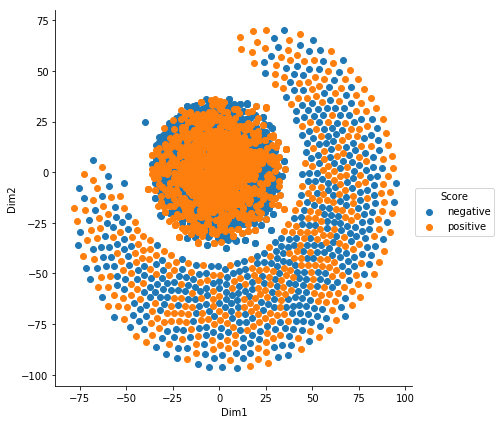

In [6]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0,perplexity = 50)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of itearations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1", "Dim2", "Score"))
print(tsne_df)
# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'Dim1', 'Dim2').add_legend()
plt.show()

### Observation:- 
    
Here, we are not able to draw a line/hyperplane to separate +ve and -ve reviews because it overlap each other. But we will have some other techniques to separates reviews.So, bow technique is not suitable for such data.

### TF-IDF

In [25]:
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(final['CleanedText'].values)

In [43]:
final_tf_idf.shape

(4000, 11532)

In [26]:
tfidf_vectors=final_tf_idf.toarray()

In [27]:
standardized_data = StandardScaler().fit_transform(tfidf_vectors)
print(standardized_data.shape)

(4000, 11532)


### t-sne using tf-idf

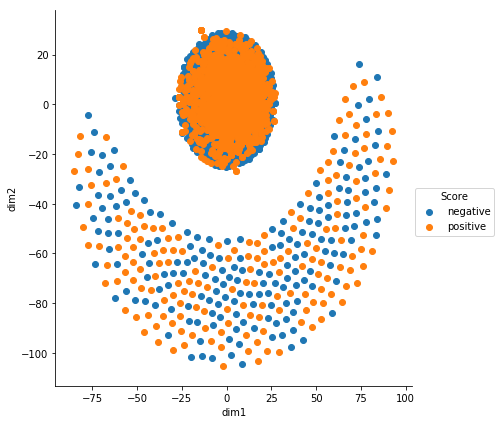

In [28]:
model = TSNE(n_components=2, random_state=0,perplexity=50)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of itearations for the optimization = 1000

tsne_data = model.fit_transform(standardized_data)
       

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.show()

### Observations:

The visualization is same as that with BOW so tf-idf technique also did not work with this data.So,now we will try one another technique.

### Word2Vec

In [14]:
# Train your own Word2Vec model using your own text corpus

list_of_sent = []
for sent in final['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [15]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [16]:
w2v = w2v_model[w2v_model.wv.vocab]

In [51]:
w2v.shape

(4376, 50)

### Avg W2V, TFIDF-W2V

In [23]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))


4000


### t-sne using Average w2v

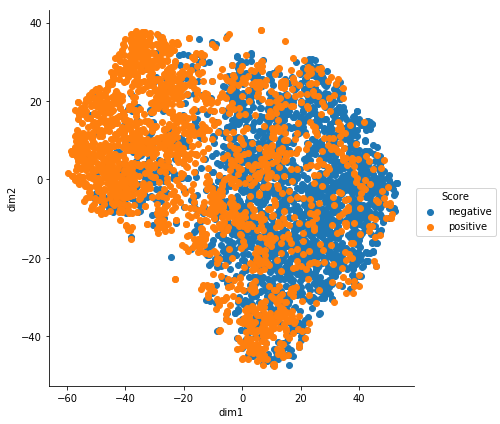

In [24]:
model = TSNE(n_components=2, random_state=0,perplexity=50)

tsne_data = model.fit_transform(sent_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()

plt.show()

### Observations:

This visualization is highly plugged between +ve and -ve reviews. So, we are unable to seprate +ve and -ve reviews. Hence this technique also failed. 

In [19]:
# TF-IDF weighted Word2Vec
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

### t-sne using tf-idf w2v

In [20]:
# To replace nan with 0 and inf with large finite number
tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

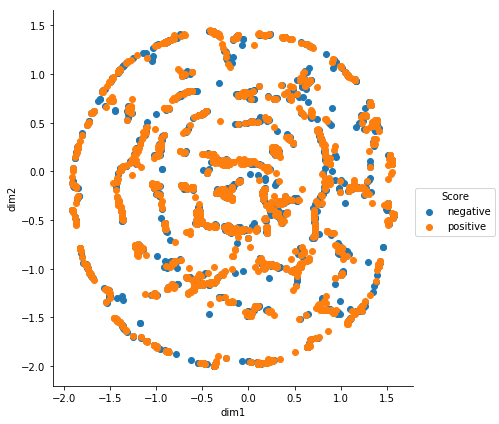

In [22]:
model = TSNE(n_components=2, random_state=0,perplexity=50)

tsne_data = model.fit_transform(tfidf_sent_vectors)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, final['Score'])).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()

plt.show()

### Observations:

This visualization is highly overlapping both +ve and -ve reviews.So, we are not able to seprate out +ve and -ve reviews from this technique also.

### Conclusions:

As we can see that none of the t-sne plots can able to seprate out +ve and -ve reviews using bow, tf-idf, avg w2v, tf-idf w2v techniques. So we will try some other alternatives to seprate +ve and -ve reviews.